In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Pretty display for notebooks
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, learning_curve, cross_validate
from sklearn.metrics import mean_squared_log_error, make_scorer

In [3]:
data = pd.read_csv('../data/train.csv')
flo_genre = pd.read_csv('../data/flo_genre_feature.csv').drop('Unnamed: 0', axis=1)
flo_age = pd.read_csv('../data/flo_age_feature.csv').drop('Unnamed: 0', axis=1)
marcel_keywords = pd.read_csv('../data/marcel_features.csv').drop('Unnamed: 0', axis=1)

data['popularity'] = np.log1p(data.popularity)
data = data.merge(flo_genre, on=['id'], how='left').merge(marcel_keywords, on=['id'], how='left').merge(flo_age, on=['id'], how='left')

data.runtime = data.runtime.fillna(np.mean(data.runtime))

features = list(flo_genre.columns) + ['popularity', 'budget', 'has_top_keyword', 'runtime']
features.remove('id')

features_df = data[features]
target = data.revenue

X_train, X_test, y_train, y_test = train_test_split(features_df, target, test_size=0.2, random_state=42)

reg = LinearRegression()
reg.fit(X_train, np.log1p(y_train))
y_pred = np.exp(reg.predict(X_test)) - 1
np.sqrt(mean_squared_log_error(y_test, y_pred))

2.2893753446503355

### Cross-validation

In [12]:
# Define own scoring function
# because target is actually log(target)
def my_score(y_true, y_pred):
    '''
    Compute the RMSLE on the actual target values, not the log target
    '''
    return np.sqrt(mean_squared_log_error(np.exp(y_true) - 1, np.exp(y_pred) - 1))

# Create callable scoring function
scoring_fnc = make_scorer(my_score)

# Do CV
cv_results = cross_validate(reg, X_train, np.log1p(y_train), cv=5, scoring=scoring_fnc, return_train_score=True)

# Display the individual results + mean/std
display(pd.DataFrame(cv_results)[['train_score', 'test_score']])
means = [
    np.mean(cv_results['train_score']),
    np.mean(cv_results['test_score'])
]
stds = [
    np.std(cv_results['train_score']),
    np.std(cv_results['test_score'])
]

result_summary = {'mean': means, 'std': stds}
display(pd.DataFrame(result_summary, index=['train_score', 'test_score']))

,train_score,test_score
0,2.405660,2.119459
1,2.349034,2.372601
2,2.297036,2.555288
3,2.319875,2.479770
4,2.355662,2.337551


,mean,std
train_score,2.345453,0.036716
test_score,2.372934,0.148437


### Learning Curves

In [40]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure(figsize=(10,5))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring_fnc)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\Cruzz\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

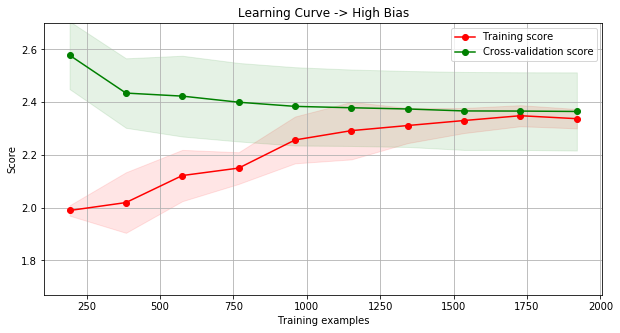

In [46]:
plot_learning_curve(reg, 'Learning Curve -> High Bias', X_train, np.log1p(y_train), cv=5, train_sizes=np.linspace(.1, 1.0, 10), ylim=(1.67, 2.7))